# NYU Stern Coding Task Notebook

**Setup**
We first import a few packages that we use today and then define a regression function that can help us when dealing regressions with Python.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from matplotlib.pyplot import figure
import patsy
import requests
from bs4 import BeautifulSoup

In [2]:
def areg(formula,data=None,absorb=None,cluster=None): 

    y,X = patsy.dmatrices(formula,data,return_type='dataframe')

    ybar = y.mean()
    y = y -  y.groupby(data[absorb]).transform('mean') + ybar

    Xbar = X.mean()
    X = X - X.groupby(data[absorb]).transform('mean') + Xbar

    reg = sm.OLS(y,X)
    # Account for df loss from FE transform
    reg.df_resid -= (data[absorb].nunique() - 1)

    return reg.fit(cov_type='cluster',cov_kwds={'groups':data[cluster].values})

**Import Data**
Then we import the data provided and use info() to first do the EDA.

In [4]:
det_epsus = pd.read_csv("det_epsus.csv")
det_epsus.info()
fundq = pd.read_csv("fundq.csv")
fundq.info()
fundq

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199908 entries, 0 to 199907
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   TICKER   199908 non-null  object 
 1   ANNDATS  199908 non-null  int64  
 2   FPI      199908 non-null  int64  
 3   FPEDATS  199908 non-null  int64  
 4   ANALYS   199908 non-null  int64  
 5   VALUE    199908 non-null  float64
 6   ACTUAL   196575 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 10.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     377 non-null    int64  
 1   datadate  377 non-null    int64  
 2   conm      377 non-null    object 
 3   rdq       377 non-null    int64  
 4   atq       377 non-null    float64
 5   cshoq     377 non-null    float64
 6   cik       377 non-null    int64  
 7   ticker    377 no

,gvkey,datadate,conm,rdq,atq,cshoq,cik,ticker
0,1045,20200331,AMERICAN AIRLINES GROUP INC,20200430,58580.000,422.887,6201,AMR
1,1075,20200331,PINNACLE WEST CAPITAL CORP,20200508,18561.760,112.492,764622,AZP
2,1078,20200331,ABBOTT LABORATORIES,20200416,66777.000,1768.845,1800,ABT
3,1161,20200331,ADVANCED MICRO DEVICES,20200428,5864.000,1171.000,2488,AMD
4,1230,20200331,ALASKA AIR GROUP INC,20200505,13363.000,122.585,766421,ALK
...,...,...,...,...,...,...,...,...
372,188255,20200331,FORTUNE BRANDS HOME & SECUR,20200430,6300.100,137.947,1519751,FBHS
373,189491,20200331,XYLEM INC,20200505,7591.000,179.900,1524472,XYL
374,260774,20200331,CBRE GROUP INC,20200507,15680.264,335.145,1138118,CBCG
375,294524,20200331,LYONDELLBASELL INDUSTRIES NV,20200501,31100.000,333.703,1489393,LALL


**TASK 1**
The following codes are for data processing. We mainly use the merge function of pandas to finish the task. 'laeps', 'lqeps', 'faeps' means last annual eps, last quarter eps and first annual eps respectively.

In [6]:
last_quarter_EPS = det_epsus[(det_epsus['FPEDATS'] == 20200331) & (det_epsus['FPI'] == 6) & (det_epsus['ANNDATS'] <= 20200331) & (det_epsus['ANNDATS'] >= 20200101)]
last_quarter_EPS = last_quarter_EPS.sort_values('FPEDATS', ascending = False).drop_duplicates(['TICKER','ANALYS'])
last_quarter_EPS = last_quarter_EPS[['TICKER','ANALYS','VALUE','ACTUAL']]
last_quarter_EPS.rename({'VALUE': 'lqeps', 'TICKER': 'ticker'}, axis='columns', inplace = True)

last_annual_EPS = det_epsus[(det_epsus['FPEDATS'] == 20201231) & (det_epsus['FPI'] == 1) & (det_epsus['ANNDATS'] <= 20200331) & (det_epsus['ANNDATS'] >= 20200101)]
last_annual_EPS = last_annual_EPS.sort_values('FPEDATS', ascending = False).drop_duplicates(['TICKER','ANALYS'])
last_annual_EPS = last_annual_EPS[['TICKER','ANALYS','VALUE','ACTUAL']]
last_annual_EPS.rename({'VALUE': 'laeps','TICKER': 'ticker'}, axis='columns', inplace = True)

first_annual_EPS = det_epsus[(det_epsus['FPEDATS'] == 20201231) & (det_epsus['FPI'] == 1) & (det_epsus['ANNDATS'] <= 20200630)]
first_annual_EPS = fundq.merge(first_annual_EPS, how = "left", left_on = "ticker", right_on = "TICKER", validate = "1:m")
first_annual_EPS = first_annual_EPS[first_annual_EPS['ANNDATS'] >= first_annual_EPS['rdq']]
first_annual_EPS = first_annual_EPS.sort_values('FPEDATS', ascending = True).drop_duplicates(['TICKER','ANALYS'])
first_annual_EPS = first_annual_EPS[['TICKER','ANALYS','VALUE','ACTUAL']]
first_annual_EPS.rename({'VALUE': 'faeps','TICKER': 'ticker'}, axis='columns', inplace = True)


fundq_1 = fundq.merge(last_quarter_EPS, how = "left", on = 'ticker', validate = "1:m")
fundq_1 = fundq_1[['ticker','ANALYS','lqeps','ACTUAL']]
fundq_2 = fundq.merge(last_annual_EPS, how = 'left', on = 'ticker', validate = "1:m")
fundq_2 = fundq_2[['ticker','ANALYS','laeps']]
fundq_3 = fundq.merge(first_annual_EPS, how = 'left', on = 'ticker', validate = "1:m")
fundq_3 = fundq_3[['ticker','ANALYS','faeps']]

fundq_1 = fundq_1.merge(fundq_2, how = 'outer', on = ['ticker','ANALYS'])
fundq_3 = fundq_3.merge(fundq_1, how = 'outer', on = ['ticker','ANALYS'])

# actual_list = []
# for index, item in fundq_3.iterrows():
#     if np.isnan(item['ACTUAL']) == False:
#         actual_list.append(item['ACTUAL'])
#     else:
#         if np.isnan(item['ACTUAL_x']) == False:
#             actual_list.append(item['ACTUAL_x'])
#         else:
#             actual_list.append(item['ACTUAL_y'])            
# fundq_3['ACTUAL'] = actual_list
# fundq_3.drop(['ACTUAL_x','ACTUAL_y'], axis = 1, inplace = True)
df = fundq.merge(fundq_3, how = 'left', on = 'ticker', validate = "1:m")
df

,gvkey,datadate,conm,rdq,atq,cshoq,cik,ticker,ANALYS,faeps,lqeps,ACTUAL,laeps
0,1045,20200331,AMERICAN AIRLINES GROUP INC,20200430,58580.0,422.887,6201,AMR,185711.0,-12.61,NaN,NaN,-4.36
1,1045,20200331,AMERICAN AIRLINES GROUP INC,20200430,58580.0,422.887,6201,AMR,122821.0,-15.09,0.04,-2.65,-14.24
2,1045,20200331,AMERICAN AIRLINES GROUP INC,20200430,58580.0,422.887,6201,AMR,152454.0,-17.20,0.30,-2.65,-2.50
3,1045,20200331,AMERICAN AIRLINES GROUP INC,20200430,58580.0,422.887,6201,AMR,118114.0,-14.54,0.32,-2.65,-12.17
4,1045,20200331,AMERICAN AIRLINES GROUP INC,20200430,58580.0,422.887,6201,AMR,146188.0,-5.06,0.45,-2.65,-4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,316056,20200331,ALLEGION PLC,20200423,2757.7,92.218,1579241,ALEE,18334.0,4.20,0.95,1.04,4.65
6714,316056,20200331,ALLEGION PLC,20200423,2757.7,92.218,1579241,ALEE,129088.0,4.35,0.91,1.04,4.60
6715,316056,20200331,ALLEGION PLC,20200423,2757.7,92.218,1579241,ALEE,107332.0,4.10,0.81,1.04,4.42
6716,316056,20200331,ALLEGION PLC,20200423,2757.7,92.218,1579241,ALEE,136937.0,4.05,0.94,1.04,4.69


**TASK 2 & 3**

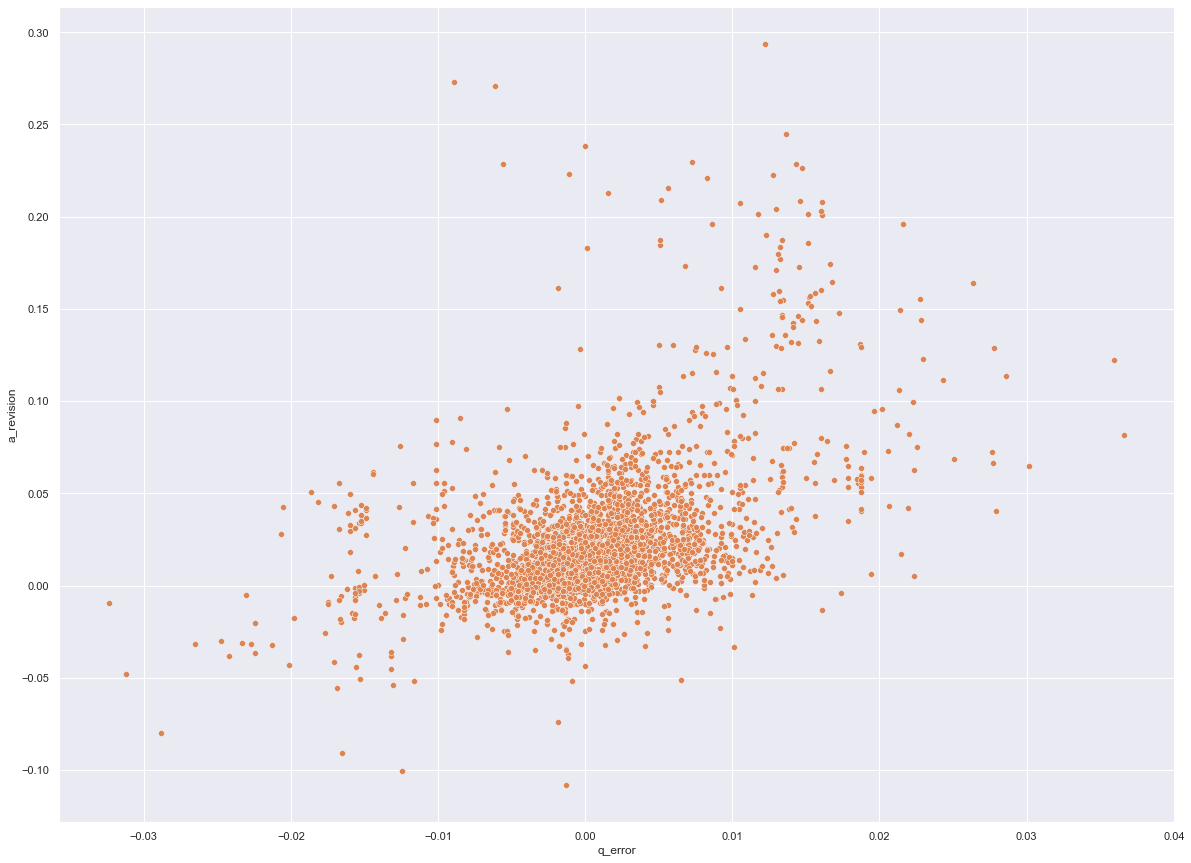

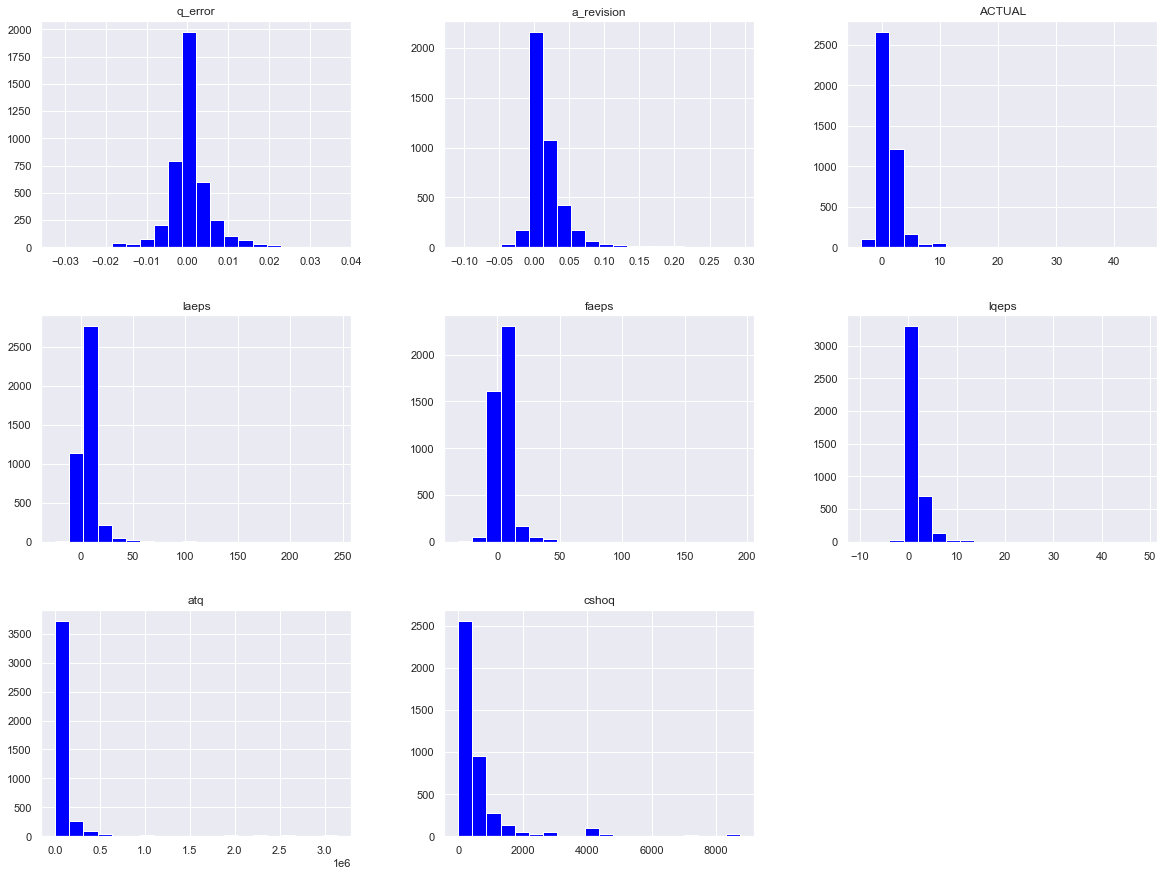

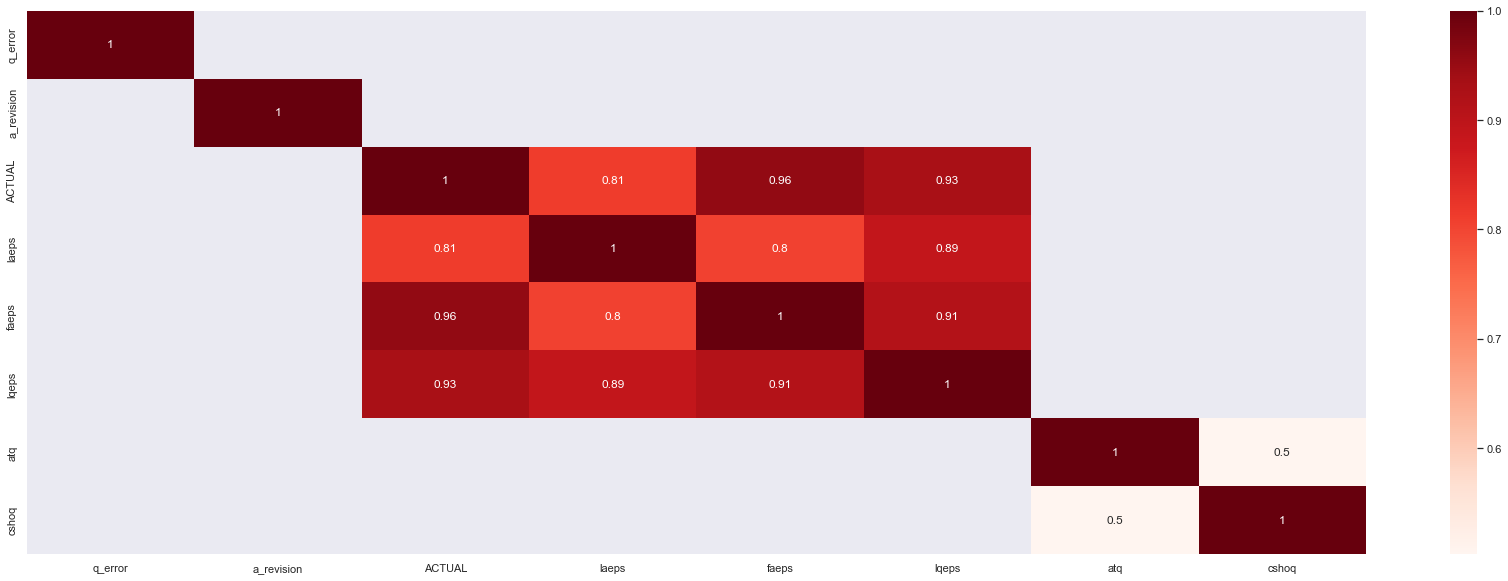

In [9]:
df['q_error'] = (df['lqeps'] - df['ACTUAL'])/df['atq']*df['cshoq']
df['a_revision'] = (df['laeps'] - df['faeps'])/df['atq']*df['cshoq']
sns.set(rc={'figure.figsize':(20, 15)})
sns.scatterplot(x = 'q_error', y = 'a_revision', data = df)
df = df[df['a_revision'] > -0.6]
df = df[df['q_error'] < 0.25]
sns.scatterplot(x = 'q_error', y = 'a_revision', data = df)
dists = df[['q_error', 'a_revision','ACTUAL','laeps','faeps','lqeps','atq','cshoq']].hist(bins=20, color='blue')
df[['q_error', 'a_revision']].describe()
plt.figure(figsize=(30,10))
df_corr = df[['q_error', 'a_revision','ACTUAL','laeps','faeps','lqeps','atq','cshoq']].corr()
df_corr_filt = df_corr[((df_corr >= .5) | (df_corr <= -.5))]
sns.heatmap(df_corr_filt, annot=True, cmap="Reds")
plt.show()

**TASK 4**

In [8]:
reg_df = df.dropna()
reg_model = areg('a_revision ~ q_error + atq', data = df,absorb = 'ANALYS', cluster='ANALYS')
reg_model.summary()

C:\Users\Steph\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             a_revision   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                 -0.209
Method:                 Least Squares   F-statistic:                     126.2
Date:                Sat, 26 Mar 2022   Prob (F-statistic):           8.74e-28
Time:                        17:00:09   Log-Likelihood:                 10520.
No. Observations:                4234   AIC:                        -2.103e+04
Df Residuals:                    3141   BIC:                        -2.101e+04
Df Model:                           2                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0173      0.000    170.379      0.000       0.017       0.018
q_error        1.8044      0.161     11.234      0.000       1.490       2.119
atq        -1.778e-09   5.76e-10     -3.087      0.002   -2.91e-09   -6.49e-10
==============================================================================
Omnibus:                     2714.269   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100616.750
Skew:                           2.506   Prob(JB):                         0.00
Kurtosis:                      26.350   Cond. No.                     6.85e+07
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 6.85e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**TASK 5**

In [11]:
indexfile = pd.read_csv("form.idx", on_bad_lines ='skip', sep = '\t')
indexfile.drop([0,1,2,3,4], inplace = True)
indexfile.columns = ['Description']
indexfile = indexfile['Description'].str.split(n = 1, expand = True)
index_df = pd.DataFrame()
index_df['Code'] = indexfile[0]
index_df['Company_Name'] = indexfile[1].str.split(pat = '    ', expand = True)[0]
iter_df = indexfile[1].str.split(pat = '  ', expand = True)

file_list = []

iter_df.fillna('1', inplace = True)
for index, rows in iter_df.iterrows():
    for item in rows:
        if item[0:5] == 'edgar':
            file_list.append(f'https://www.sec.gov/Archives/{item}')   
index_df['path'] = file_list
index_df

,Code,Company_Name,path
5,1-A,"Alt 5 Sigma, Inc.",https://www.sec.gov/Archives/edgar/data/176931...
6,1-A,"American Condor Resources, Corp",https://www.sec.gov/Archives/edgar/data/175425...
7,1-A,"American Condor Resources, Corp",https://www.sec.gov/Archives/edgar/data/175425...
8,1-A,Atlis Motor Vehicles Inc,https://www.sec.gov/Archives/edgar/data/172296...
9,1-A,Audition Showdown Inc.,https://www.sec.gov/Archives/edgar/data/181109...
...,...,...,...
265479,X-17A-5/A,MIDDLEMARCH SECURITIES LLC,https://www.sec.gov/Archives/edgar/data/167076...
265480,X-17A-5/A,"MVP FINANCIAL, LLC",https://www.sec.gov/Archives/edgar/data/134091...
265481,X-17A-5/A,"MVP FINANCIAL, LLC",https://www.sec.gov/Archives/edgar/data/134091...
265482,X-17A-5/A,SAMI BROKERAGE LLC,https://www.sec.gov/Archives/edgar/data/798377...


In [ ]:
headers = { 'User-Agent': 'Mozilla/5.0', }
date_list = []
num = len('FILED AS OF DATE:		')
for item in file_list:
    r = requests.get(item, stream = True, headers = headers)
    start = r.text.find('FILED AS OF DATE:		') + num
    end = start + 8
    date_list.append(item[start:end])

index_df['path'] = date_list